In [1]:
import statistics
import pickle
import argparse
import time
import matplotlib.pyplot as plt
from itertools import count
import numpy as np
import heapq as hq
import queue
import contextlib
from scipy.stats import skewnorm
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.markers import MarkerStyle

In [2]:
class defectRemediationSimulator:
    def __init__(self, defect_types,
                 defect_priority, 
                 maxValue_incoming, 
                 maxValue_outgoing,
                 skewness_incoming,
                 skewness_outgoing,
                 initial_backlogs,
                 t_end,
                 resources,
                 resources_qmax):
        self.defect_types = defect_types
        defect_priority_dict = {name: defect_priority[index] for index, name in enumerate(defect_types)}
        self.defect_priority = defect_priority_dict
        maxValue_incoming_dict = {name: maxValue_incoming[index] for index, name in enumerate(defect_types)}
        self.maxValue_incoming = maxValue_incoming_dict
        maxValue_outgoing_dict = {name: maxValue_outgoing[index] for index, name in enumerate(defect_types)}
        self.maxValue_outgoing = maxValue_outgoing_dict
        skewness_incoming_dict = {name: skewness_incoming[index] for index, name in enumerate(defect_types)}
        self.skewness_incoming = skewness_incoming_dict
        skewness_outgoing_dict = {name: skewness_outgoing[index] for index, name in enumerate(defect_types)}
        self.skewness_outgoing = skewness_outgoing_dict
        initial_dict = {name: initial_backlogs[index] for index, name in enumerate(defect_types)}
        self.initial_backlogs = initial_dict

        self.t_end = t_end
        self.resources = resources
        self.resources_qmax = resources_qmax

    def generate_type_dict(self):
        defect_type_dict = {}
        for name in self.defect_types:
            defect_type_dict[name] = {'priority': self.defect_priority[name],
                                      'skewness_outgoing': self.skewness_outgoing[name], 
                                      'skewness_incoming': self.skewness_incoming[name], 
                                      'maxValue_incoming': self.maxValue_incoming[name], 
                                      'maxValue_outgoing': self.maxValue_outgoing[name],
                                      'initial': self.initial_backlogs[name]}
            

        self.defect_type_dict = defect_type_dict
        return defect_type_dict ###### returned for visualization purposes - is this necessary?
    
    def generate_distributions(self, size=1000):
        # distributions = []
        incoming_distributions = {}
        outgoing_distributions = {}
        for name in self.defect_types:
            #### "Incoming distribution" samples incoming defects/hr ####
            maxValue= self.maxValue_incoming[name]
            samples_incoming = skewnorm.rvs(self.skewness_incoming[name], size=size)
            samples_incoming_pos = samples_incoming - min(samples_incoming)              # positive values only   
            samples_incoming_pos = samples_incoming_pos / max(samples_incoming_pos)      # standadize all the values between 0 and 1 
            samples_incoming_pos = samples_incoming_pos * maxValue                       # spread the standardized values over the range defined by "maxValue"

            #### "Outgoing distribution" samples remediation time [hrs] #### 
            maxValue_outgoing = self.maxValue_outgoing[name]
            samples_outgoing = skewnorm.rvs(self.skewness_outgoing[name], size=size)
            samples_outgoing_pos = samples_outgoing - min(samples_outgoing)           
            samples_outgoing_pos = samples_outgoing_pos / max(samples_outgoing_pos)
            samples_outgoing_pos = samples_outgoing_pos * maxValue_outgoing
            # samples_outgoing_pos = [item + abs(min(samples_outgoing)) for item in samples_outgoing]
            
            incoming_distributions[name] = np.round(samples_incoming_pos) # rounds to nearest integer, for values exactly halfway between, rounds to the nearest even value, e.g. 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0
            outgoing_distributions[name] = samples_outgoing_pos

        self.generation_distributions = incoming_distributions
        self.remediation_distributions = outgoing_distributions
        return incoming_distributions, outgoing_distributions ###### returned for visualization purposes - is this necessary?
    
    def compute_time_step(self):
        minvals = []
        for defect_type in self.defect_type_dict.keys():
            temp_list = self.remediation_distributions[defect_type].copy()
            try:
                min_sample = np.min(temp_list[np.nonzero(temp_list)])
                if min_sample < 1: # min sample must be less than the defect generation time step = 1 hr
                    minvals.append(min_sample)
                else:
                    minvals.append(1)
            except ValueError:
                minvals.append(1)
                    
        dt = min(minvals)/2
        return dt

    def load_initial_state(self, initial_state, defect_log, backlog_queue):
        t_start = initial_state['t_end']
        t_end = t_start + self.t_end
        defect_log = initial_state['defect_log']
        for key in defect_log.keys():
            try:
                defect_log[key]['processing_end_time'] ### defect in initial_state has been remediated, it does not get added to the backlog_queue
            except KeyError:
                ### defect has not been remediated yet, add it to the backlog_queue
                hq.heappush(backlog_queue, (self.defect_type_dict[defect_log[key]['defect_type']]['priority'], key)) # tuple (priority level, defect ID tag) will be sorted in heap based on priority
        return t_start, t_end, defect_log, backlog_queue

    def initialize_backlog(self, t_start, defect_log, backlog_queue):
        #### INITIALIZATION OF THE BACKLOG ####
        for key in self.defect_type_dict.keys():
            # if self.defect_type_dict[key]['initial'] != 0:
            for i in range(self.defect_type_dict[key]['initial']):
                defect_ID = 'ID_' + str(np.random.randint(1,1000000000))
                remediation_time = np.random.choice(self.remediation_distributions[key], size=1, replace=True)
                defect_log[defect_ID] = {'defect_type': key, 't_created': t_start, 'remediation_time': remediation_time}
                # backlog_queue.put(defect_ID, block=False)
                hq.heappush(backlog_queue, (self.defect_type_dict[key]['priority'], defect_ID)) # tuple (priority level, defect ID tag) will be sorted in heap based on priority
        return defect_log, backlog_queue

    def initialize_queues(self, t_start, defect_log, backlog_queue):
        queue_dict = {} 
        #### INITALIZATION OF THE REMEDIATION QUEUES ####
        for n in range(1, self.resources + 1):
            queue_dict['processing_queue{0}'.format(n)] = queue.Queue(maxsize=self.resources_qmax)
            for _ in range(self.resources_qmax):
                with contextlib.suppress(IndexError):
                    if defect_pull := hq.heappop(backlog_queue)[1]:
                # with contextlib.suppress(queue.Empty):
                #     if defect_pull := backlog_queue.get(block=False): #####
                        queue_dict['processing_queue{0}'.format(n)].put(defect_pull, block=False)
                        try:
                            check_var = defect_log[defect_pull]['processing_start_time'] # remediation was already begun in a previous state, continue from where it left off
                        except KeyError:
                            # remediation has not started, start it from now
                            defect_log[defect_pull]['processing_start_time'] = t_start + 0
                        defect_log[defect_pull]['processing_queue'] = 'processing_queue{0}'.format(n)
        return queue_dict, defect_log, backlog_queue

    def incoming_defects(self, t, incoming_defects_tracker, incoming_defects_stored, defect_log, backlog_queue):
        for key in incoming_defects_tracker.keys():
            incoming_defects_stored[key].append(incoming_defects_tracker[key][0])
            defect_ID = ['ID_' + str(np.random.randint(1,1000000000)) for _ in range(int(incoming_defects_tracker[key][0]))] ### one defect ID per defect that came in in that hour
            priority_level = [self.defect_type_dict[key]['priority'] for _ in range(int(incoming_defects_tracker[key][0]))]
            remediation_time = [np.random.choice(self.remediation_distributions[key], size=1, replace=True) for _ in range(int(incoming_defects_tracker[key][0]))]
            defect_log.update({defect_ID[i]: {'defect_type': key, 't_created': t, 'remediation_time': remediation_time[i]} for i in range(int(incoming_defects_tracker[key][0]))})
            # list(map(backlog_queue.put, defect_ID))
            backlog_queue = backlog_queue + list(zip(priority_level, defect_ID))
            hq.heapify(backlog_queue)
            incoming_defects_tracker[key] = np.random.choice(self.generation_distributions[key], size=1, replace=True) ### reinitialize the incoming_defects_tracker
        return incoming_defects_tracker, incoming_defects_stored, defect_log, backlog_queue

    def check_queues(self, n, t, queue_dict, defect_log, backlog_queue):
        if queue_dict['processing_queue{0}'.format(n)].qsize() < self.resources_qmax:
            for i in range(self.resources_qmax - queue_dict['processing_queue{0}'.format(n)].qsize()):
                with contextlib.suppress(IndexError):
                    if defect_pull := hq.heappop(backlog_queue)[1]:
                        queue_dict['processing_queue{0}'.format(n)].put(defect_pull, block=False)
                        defect_log[defect_pull]['processing_start_time'] = t
                        defect_log[defect_pull]['processing_queue'] = 'processing_queue{0}'.format(n)
        return queue_dict, defect_log, backlog_queue 

    def check_remediation(self, n, t, queue_dict, defect_log, backlog_queue):
        for _ in range(self.resources_qmax):
            with contextlib.suppress(queue.Empty):
                if processing_defect := queue_dict['processing_queue{0}'.format(n)].get(block=False): #####
                    if (t - defect_log[processing_defect]['processing_start_time'] >= defect_log[processing_defect]['remediation_time']) and (defect_log[processing_defect]['remediation_time'] != 0):
                        ### defect has been remediated, updated processing_end_time + pick a new defect from the backlog queue to treat
                        leftover_outgoing = (t - defect_log[processing_defect]['processing_start_time']) - defect_log[processing_defect]['remediation_time']
                        defect_log[processing_defect]['processing_end_time'] = t - leftover_outgoing
                        with contextlib.suppress(IndexError):
                            if defect_pull := hq.heappop(backlog_queue)[1]:
                                queue_dict['processing_queue{0}'.format(n)].put(defect_pull, block=False)
                                defect_log[defect_pull]['processing_start_time'] = t - leftover_outgoing
                                defect_log[defect_pull]['processing_queue'] = 'processing_queue{0}'.format(n)
                    else:
                        ### defect has not finished being remediated, put the processing_defect back into the queue
                        queue_dict['processing_queue{0}'.format(n)].put(processing_defect, block=False)
        return queue_dict, defect_log, backlog_queue
        
    
    def simulate_defect_backlog(self, dt, initial_state):
        t_start = 0 # assume that starting time of the simulation is now to initialize
        t_end = self.t_end
        defect_log = {}
        backlog_queue = []

        #### IF AVAILABLE, LOAD IN INITIAL STATE ####
        if initial_state:
            t_start, t_end, defect_log, backlog_queue = self.load_initial_state(initial_state, defect_log, backlog_queue)
            
        times1 = np.arange(t_start, t_end, dt) # time step array
        times2 = np.arange(t_start+1, t_end+1) # "on the hour" array (for defect generation)
        times = np.sort(np.concatenate((times1, times2), axis=0))


        defect_log, backlog_queue = self.initialize_backlog(t_start, defect_log, backlog_queue)
        queue_dict, defect_log, backlog_queue = self.initialize_queues(t_start, defect_log, backlog_queue)

        #### INITIALIZATION OF INCOMING DEFECT TRACKER ####
        incoming_defects_tracker = {key: np.random.choice(self.generation_distributions[key], size=1, replace=True) for key in self.defect_type_dict.keys()}
        incoming_defects_stored = {key: [] for key in self.defect_type_dict.keys()}
        hour = t_start + 1.0
        ## {'type1': 20, 'type2': 5, 'type3': 4}

        
        #### LOOP OVER TIME ####
        for t in times:
            #### INCOMING "ON THE HOUR" DEFECTS ####
            if t == hour:
                incoming_defects_tracker, incoming_defects_stored, defect_log, backlog_queue = self.incoming_defects(t, incoming_defects_tracker, incoming_defects_stored, defect_log, backlog_queue)
                hour += 1
            
            #### UPDATE REMEDIATION ####
            for n in range(1, self.resources + 1):
                ### first check if processing_queue{n} is empty or not filled to resources_qmax
                queue_dict, defect_log, backlog_queue = self.check_queues(n, t, queue_dict, defect_log, backlog_queue)
                
                ### next check if each defect in processing_queue{n} has been remediated at time t
                queue_dict, defect_log, backlog_queue = self.check_remediation(n, t, queue_dict, defect_log, backlog_queue)
                
        return np.array(times), incoming_defects_stored, defect_log, backlog_queue

In [3]:
#### INPUT PARAMETER ####
# parser = argparse.ArgumentParser()
# parser.add_argument('--defect_labels', type=str, help='List defect types to simulate seperated by ,')
# parser.add_argument('--defect_priority', type=str, help='List defect priorities for each defect type in --defect_labels (lower = higher priority) seperated by ,')
# parser.add_argument('--maxValue_generation', type=str, help='List max value of incoming defect distribution for each defect type in --defect_labels seperated by ,')
# parser.add_argument('--maxValue_remediation', type=str, help='List max value of remediation time distribution for each defect type in --defect_labels seperated by ,')
# parser.add_argument('--skewness_generation', type=str, help='List skewness of incoming defect distribution for each defect type in --defect_labels seperated by ,')
# parser.add_argument('--skewness_remediation', type=str, help='List skewness of remediation time distribution for each defect type in --defect_labels seperated by ,')
# parser.add_argument('--initial_backlogs', type=str, help='List initial number of backlogged defects for each defect type in --defect_labels seperated by ,')
# parser.add_argument('--t_end', type=float, help='End time for remediation simulation, in hours')
# parser.add_argument('--resources', type=int, help='Available parallel resources for treatment of defects')
# parser.add_argument('--resources_qmax', type=int, help='Maxmimum resources that can be alloted at any given time for treatment of defects')
# parser.add_argument('--trials', type=int, help='Number of times to run the full simulation')
# parser.add_argument('--check_initial_state', default=False, help='If importing an existing simulation to continue, enter True; False otherwise')
# parser.add_argument('--export_final_state', default=False, help='If exporting current simulation, enter True; False otherwise')
# ### add paths for importing + exporting

# if __name__ == "__main__":
# args = parser.parse_args()
#### Initialization variables ####
defect_labels = ['type1', 'type2', 'type3', 'type4', 'type5']
defect_priority = [11, 3, 4, 10, 8]
maxValue_generation = [1, 2, 1, 2, 2]
# maxValue_generation = [0, 0, 0, 0, 0]
# maxValue_remediation = [3.5, 4, 5.5, 4, 5]
maxValue_remediation = [0, 0, 0, 0, 0]
skewness_generation = [5, 2, 0, -10, -3]
skewness_remediation = [-3, 2, -1, 4, -1]
initial_backlogs = [20, 1, 12, 3, 14]
# initial_backlogs = [10, 5, 20, 5, 20]
# initial_backlogs = [0, 0, 0, 0, 0]

#### Simulation variables ####
t_end = 0
resources = 0
resources_qmax = 2
trials = 5
check_initial_state = True
export_final_state = False
# if args.check_initial_state == 'True':
#     check_initial_state = True
# else:
#     check_initial_state = False
# if args.export_final_state == 'True':
#     export_final_state = True
# else:
#     export_final_state = False

# print(check_initial_state, export_final_state)


####### INITIALIZATION ########
#### LOAD IN EXISTING STATE ####
if check_initial_state:
    with open('datasets/Example1_09042025.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    trials = len(loaded_dict.keys())
    initial_backlogs = [0, 0, 0, 0, 0]


defect_simulation = defectRemediationSimulator(defect_labels,
                                               defect_priority,
                                               maxValue_generation,
                                               maxValue_remediation,
                                               skewness_generation,
                                               skewness_remediation,
                                               initial_backlogs,
                                               t_end,
                                               resources,
                                               resources_qmax)

defect_type_dict = defect_simulation.generate_type_dict() # map defect type to corresponing poisson_rate, skewness and initial_backlogs
generation_distributions, remediation_distributions = defect_simulation.generate_distributions() # generate remediation time distribution for each defect type
dt = defect_simulation.compute_time_step()
### histogram of distributions

####### BACKLOG SIMULATION ########
comparison_dict = {}
for i in range(trials):
    start = time.time()
    # test = defectBacklog(t_end = t_end,
    #             resources = resources,
    #             resources_qmax = resources_qmax,
    #             defect_type_dict = defect_type_dict,
    #             generation_distributions = generation_distributions,
    #             remediation_distributions = remediation_distributions)
    # dt = test.compute_time_step()
    if check_initial_state:
        initial_state = loaded_dict['trial{0}'.format(i+1)]
    else:
        initial_state = {}
    times, incoming_defects, defect_log, backlog_queue_remaining = defect_simulation.simulate_defect_backlog(dt, initial_state)
    end = time.time()
    if t_end != 0:
        comparison_dict['trial{0}'.format(i+1)] = {'simulation_time': end-start, 't_end': times[-1], 'time_step': dt, 'defect_log': defect_log}
    else:
        try:
            comparison_dict['trial{0}'.format(i+1)] = {'simulation_time': end-start, 't_end': initial_state['t_end'], 'time_step': dt, 'defect_log': defect_log}
        except KeyError:
            ### t_end = 0 and initial_state empty, no simulation was done, considers only the initial conditions at t = 0
            comparison_dict['trial{0}'.format(i+1)] = {'simulation_time': end-start, 't_end': 0, 'time_step': dt, 'defect_log': defect_log}
        
    print(f'Elapsed time (trial {i+1}):', end-start, 'seconds')

### SAVE SIMULATION RESULTS AS JSON ####
if export_final_state:
    with open('pickled_dictionaries/Test_24032025.pkl', 'wb') as f:
        pickle.dump(comparison_dict, f)


Elapsed time (trial 1): 0.0 seconds
Elapsed time (trial 2): 0.0013508796691894531 seconds
Elapsed time (trial 3): 0.0 seconds
Elapsed time (trial 4): 0.0 seconds
Elapsed time (trial 5): 0.0 seconds


In [4]:
defect_log

{'ID_372409724': {'defect_type': 'type1',
  't_created': 0,
  'remediation_time': array([2.38844961]),
  'processing_start_time': array([4.77300687]),
  'processing_queue': 'processing_queue1',
  'processing_end_time': array([7.16145648])},
 'ID_191161199': {'defect_type': 'type1',
  't_created': 0,
  'remediation_time': array([1.86169988]),
  'processing_start_time': array([4.30014486]),
  'processing_queue': 'processing_queue2',
  'processing_end_time': array([6.16184474])},
 'ID_876338449': {'defect_type': 'type1',
  't_created': 0,
  'remediation_time': array([2.21885183]),
  'processing_start_time': array([6.42560835]),
  'processing_queue': 'processing_queue9',
  'processing_end_time': array([8.64446019])},
 'ID_943626092': {'defect_type': 'type1',
  't_created': 0,
  'remediation_time': array([2.16458949]),
  'processing_start_time': array([6.50908435]),
  'processing_queue': 'processing_queue8',
  'processing_end_time': array([8.67367384])},
 'ID_952428191': {'defect_type': 'ty

In [69]:
# example_log = pd.DataFrame.from_dict(defect_log, orient='index')
# example_log.to_csv('example_log.csv')

### Answering questions ####

In [70]:
#### ANSWERING QUESTION 1 ####
# How long on average is defect waiting in backlog before beginning remediation?
avg_time = 0
length = 0
for trial in comparison_dict.keys():
    for defect in comparison_dict[trial]['defect_log'].keys():
        avg_time = avg_time + (comparison_dict[trial]['defect_log'][defect]['processing_start_time'] - comparison_dict[trial]['defect_log'][defect]['t_created'])
        length += 1
print(avg_time, length)
avg_time = avg_time/length
avg_time_mins = avg_time * 60
print(avg_time, avg_time_mins)
    

[554.89869212] 250
[2.21959477] [133.17568611]


In [71]:
#### ANSWERING QUESTION 2 ####
# What processing queue treated the most defects?
for trial in comparison_dict.keys():
    print(pd.DataFrame.from_dict(defect_log, orient='index')['processing_queue'].value_counts().index[0])
    print(pd.DataFrame.from_dict(defect_log, orient='index')['processing_queue'].value_counts().iloc[0])

processing_queue1
6
processing_queue1
6
processing_queue1
6
processing_queue1
6
processing_queue1
6


In [72]:
#### ANSWERING QUESTION 3 ####
# Including waiting time, how long does it take on average to remediate a defect?
avg_time = 0
length = 0
for trial in comparison_dict.keys():
    for defect in comparison_dict[trial]['defect_log'].keys():
        try: 
            avg_time = avg_time + (comparison_dict[trial]['defect_log'][defect]['processing_end_time'] - comparison_dict[trial]['defect_log'][defect]['t_created'])
            length += 1
        except KeyError:
            pass
print(avg_time, length)
avg_time = avg_time/length
avg_time_mins = avg_time * 60
print(avg_time, avg_time_mins)

[1233.76139545] 250
[4.93504558] [296.10273491]


In [73]:
remed_coeff_dict

{}

In [74]:
#### ANSWERING QUESTION 4 ####
# How many defects are being generated / remediated per hour? [remediation ratio generated/remediated, if >1 backlog growing, if <1 backlog decreasing]
test_df = pd.DataFrame.from_dict(defect_log, orient='index')
remed_coeff_dict = {}
for i in range(1, 50+1):
    # try:
    generations = test_df['t_created'].value_counts().loc[i]
    # except KeyError:
    # generations = 0
    # try:
    # remediations = test_df.query(f'(processing_end_time > {i-1}) and (processing_end_time < {i})').count()['processing_end_time']
    # except KeyError:
    remediations = 0
    remed_coeff_dict[i] = {'generated': generations, 'remediated': remediations, 'coefficient': round(generations/remediations,2)}

avg_generated, avg_remediated, avg_coefficient = 0, 0, 0
for key in remed_coeff_dict.keys():
    avg_generated += remed_coeff_dict[key]['generated']
    avg_remediated += remed_coeff_dict[key]['remediated']
    avg_coefficient += remed_coeff_dict[key]['coefficient']

avg_generated, avg_remediated, avg_coefficient = avg_generated/len(remed_coeff_dict), avg_remediated/len(remed_coeff_dict), avg_coefficient/len(remed_coeff_dict)
print(avg_generated, avg_remediated, avg_coefficient)

KeyError: 1

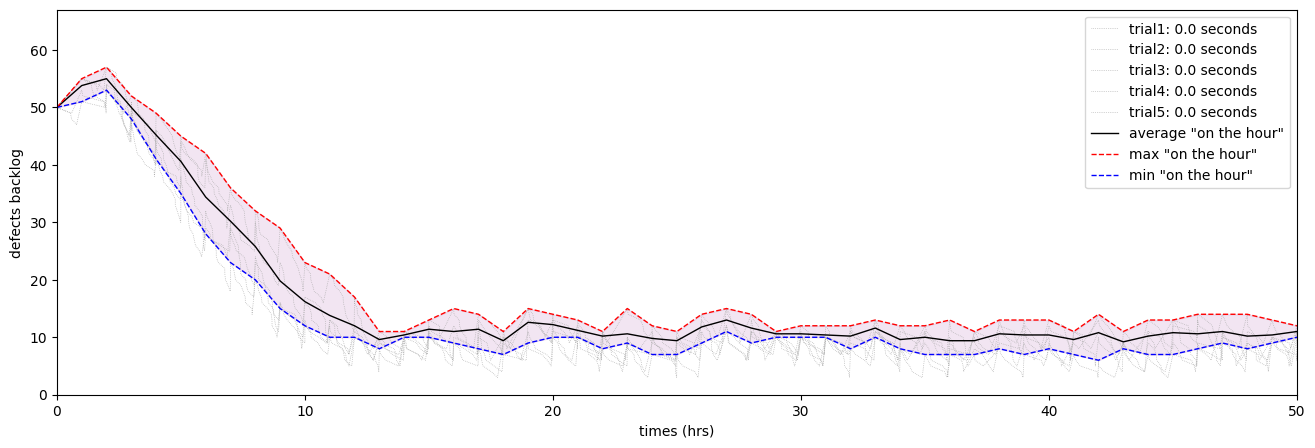

In [5]:
#### VISUALIZATION ---- MOVE TO FUNCTION ####
#### MULTIPLE TRIALS ####
defects_created = {}
defects_remediated = {}
list_remediated = {}
list_remediated_forplot = {}
times = {}
times_forplot = {}
backlog = {}
# backlog2 = {}
# test = []

for trial in comparison_dict.keys():
    t_end = int(comparison_dict[trial]['t_end'])
    hours = list(range(t_end+1))
    initial_backlog = sum([1 for key in comparison_dict[trial]['defect_log'].keys() if comparison_dict[trial]['defect_log'][key]['t_created'] == 0])
    defects_created[trial] = {}
    defects_remediated[trial] = {}
    for key in comparison_dict[trial]['defect_log'].keys():
        defects_created[trial][key] = comparison_dict[trial]['defect_log'][key]['t_created']
        try:
            defects_remediated[trial][key] = comparison_dict[trial]['defect_log'][key]['processing_end_time']
        except KeyError:
            # test.append(1)
            pass

    list_remediated[trial] = [defects_remediated[trial][key] for key in defects_remediated[trial].keys()]
    list_remediated_forplot[trial] = [defects_remediated[trial][key][0] for key in defects_remediated[trial].keys()] # remove the np.ndarray for the values to be plotted
    times[trial] = sorted(list(range(t_end+1)) + list_remediated[trial]) # keep np.ndarray to distinguish between "on the hour" generated and remediated
    times_forplot[trial] = sorted(list(range(t_end+1)) + list_remediated_forplot[trial])
    backlog[trial] = []
    # backlog2[trial] = []

    niter = count(0)
    for t in times[trial]:
    # print(t)
        if t == 0:
            backlog[trial].append(initial_backlog)
        elif type(t) == np.ndarray:
        # elif t in list_remediated[trial]:
            value = backlog[trial][next(niter)] - 1
            backlog[trial].append(value)
            # backlog2[trial].append([t, value])
            # nprevious += 1
            # niter_remediated += 1
        elif t in list(defects_created[trial].values()):
            res = sum(int(value) == t for value in defects_created[trial].values())
            value = backlog[trial][next(niter)] + res
            backlog[trial].append(value)
            # backlog2[trial].append([t, value])
            # nprevious += 1
        else:
            backlog[trial].append(backlog[trial][next(niter)])

backlog_max = max(i for v in backlog.values() for i in v)
backlog_min = min(i for v in backlog.values() for i in v)

fig, ax = plt.subplots(1, 1, figsize=(16,5))
backlog_avg = {}
trial_avg = [0] * len(hours)
trial_max = [backlog_min] * len(hours)
trial_min_hours = [backlog_max] * len(hours)

# backlog_min_values = {}
# min_xpoints = np.arange(0,t_end+0.1,0.1)
# trial_min = [backlog_max] * len(min_xpoints)
# for trial in times_forplot.keys():
#     temp_list = []
#     half_step_values = []
#     for value in min_xpoints:
#             time_value = min(times_forplot[trial], key=lambda x:abs(x-value))
#             half_step_values.append(time_value) 
#             # trial1_list.append(time_value)
#             index_for_backlog = times_forplot[trial].index(time_value)
#             temp_list.append(backlog[trial][index_for_backlog])
#     backlog_min_values[trial] = temp_list
#     backlog_min_values[trial]['Timestep_values'] = half_step_values

for trial in times_forplot.keys():
    # times[trial] = [item[0] if type(item) == np.ndarray else item for item in times[trial]]
    ax.plot(times_forplot[trial], backlog[trial], ':', linewidth=0.5, color='darkgray', label=f"{trial}: {round(comparison_dict[trial]['simulation_time'],2)} seconds")
    backlog_avg[trial] = [backlog[trial][index] for index, value in enumerate(times[trial]) if (value in hours) and (type(value) != np.ndarray)]
    trial_avg = [trial_avg[index] + value for index, value in enumerate(backlog_avg[trial])]
    trial_max = [value if value > trial_max[index] else trial_max[index] for index, value in enumerate(backlog_avg[trial])]
    trial_min_hours = [value if value < trial_min_hours[index] else trial_min_hours[index] for index, value in enumerate(backlog_avg[trial])]
    # trial_min = [value if value < trial_min[index] else trial_min[index] for index, value in enumerate(backlog_min_values[trial])]


trial_avg = [x/trials for x in trial_avg]
ax.plot(hours, trial_avg, 'k', linewidth=1, label='average "on the hour"')
ax.plot(hours, trial_max, 'r--', linewidth=1, label='max "on the hour"')
ax.plot(hours, trial_min_hours, 'b--', linewidth=1, label='min "on the hour"')
# ax.plot(min_xpoints, trial_min, 'c--', linewidth=1, label='min "on the hour"')

# for i in range(len(comparison_dict)):

# for key in defect_log.keys():
#     try:
#         index = np.where(np.array(times) == defect_log[key]['processing_end_time'])
#         # print(index[0].item())
#         ax.plot(defect_log[key]['processing_end_time'], backlog[index[0].item()], 'bo')
#         ax.annotate(f'{key}', (defect_log[key]['processing_end_time'],backlog[index[0].item()]))
#                     # arrowprops='fancy')
#     except KeyError:
#         pass
ax.set_xlabel('times (hrs)')
ax.set_ylabel('defects backlog')
ax.set_xlim(0, max(times_forplot[trial]))
ax.set_ylim(0, backlog_max+10)
ax.legend()

ax.fill_between(hours, trial_min_hours, trial_max, color='purple', alpha=0.1)
# plt.savefig('images/Example3b.png', bbox_inches='tight')
plt.show()

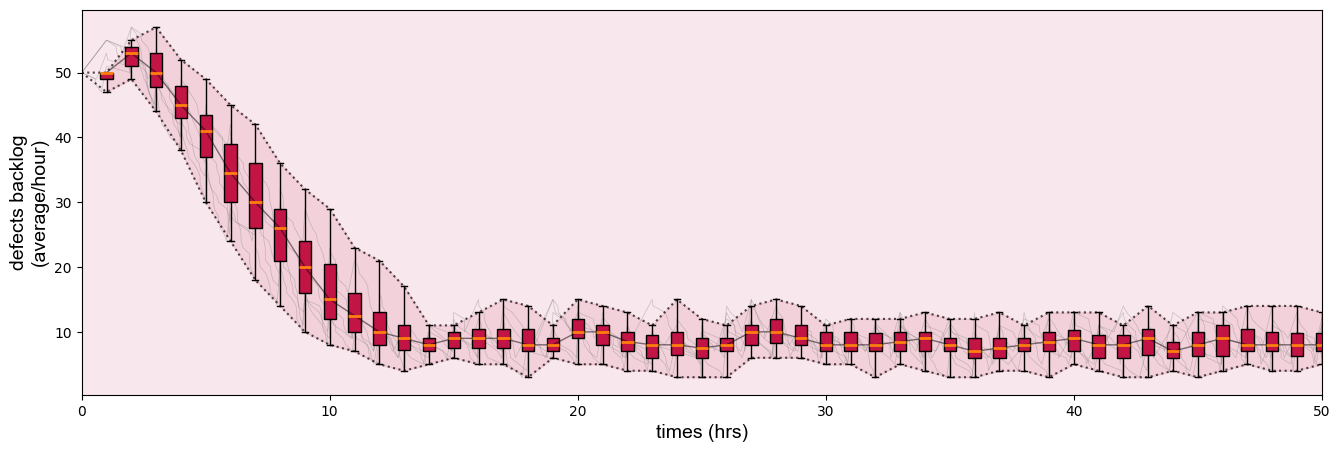

In [6]:
hourly_stats = {}
median_curve = []
min_curve = []
max_curve = []

for hour in hours[:-1]:
    hourly_stats['hour{0}'.format(hour+1)] = []
    for trial in times_forplot.keys():
        starting = times_forplot[trial].index(hours[hour])
        stopping = times_forplot[trial].index(hours[hour+1])
        hourly_stats['hour{0}'.format(hour+1)] = hourly_stats['hour{0}'.format(hour+1)] + backlog[trial][starting:stopping]
    median_curve.append(np.percentile(hourly_stats['hour{0}'.format(hour+1)],[50])[0])
    min_curve.append(min(hourly_stats['hour{0}'.format(hour+1)]))
    max_curve.append(max(hourly_stats['hour{0}'.format(hour+1)]))

# colors = ['#2348FF' if value < max(median_curve)*0.2 else '#C21445' for value in median_curve]
# colors = ['#2348FF' if value < max(median_curve)*0.17 else '#C21445' for value in median_curve]
# colors = ['green' if value < max(median_curve)*0.2 else 'yellow' for value in median_curve]
colors = ['#C21445' for value in median_curve]
# colors = ['#2348FF' for value in median_curve]


medianprops = dict(linestyle='-.', linewidth=2)


fig, ax = plt.subplots(1, 1, figsize=(16,5))
for trial in times_forplot.keys():
    ax.plot(times_forplot[trial], backlog[trial], '-', linewidth=0.5, color='gray', alpha=0.4)
# for key in hourly_stats.keys():
bplot = ax.boxplot(list(hourly_stats.values()),
                   whis=(0,100),
                   medianprops=medianprops,
                   labels=hours[1:],
                   patch_artist=True,
                   sym='x',
                   notch=False)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


ax.plot(hours, [trial_avg[0]]+max_curve, 'k:', linewidth=1.5, alpha=0.7)
# ax.plot(hours[1:], max_curve, 'r', linewidth=0.75, alpha=0.3)
ax.plot(hours[1:], median_curve, 'k', linewidth=1, alpha=0.5, label='average "on the hour"')
ax.plot(hours, [trial_avg[0]]+min_curve, 'k:', linewidth=1.5, alpha=0.7)
# ax.plot(hours[1:], min_curve, 'b', linewidth=0.75, alpha=0.3)
# ax.fill_between(hours[1:], min_curve, max_curve, color='#2348FF', alpha=0.1)
ax.fill_between(hours[1:], min_curve, max_curve, color='#C21445', alpha=0.1)
# ax.fill_between(hours[0:12], [trial_avg[0]]+min_curve[0:11], [trial_avg[0]]+max_curve[0:11], color='#C21445', alpha=0.1)
# ax.fill_between(hours[11:52], min_curve[10:51], max_curve[10:51], color='#2348FF', alpha=0.1)
# ax.fill_between(hours[51:64], min_curve[50:63], max_curve[50:63], color='#C21445', alpha=0.1)
# ax.fill_between(hours[63:], min_curve[62:], max_curve[62:], color='#2348FF', alpha=0.1)


# GetCleanbox = [Rectangle((0,-10), 11.5, 90), Rectangle((11.5,-10), max(times_forplot[trial]), 90)]
# GetCleanbox = [Rectangle((0,-10), 9.5, 90), Rectangle((9.5,-10), max(times_forplot[trial]), 90)]
# GetCleanbox = [Rectangle((0,-10), 11.5, 90), Rectangle((11.5,-10), 39, 90), Rectangle((50.5,-10), 12, 90), Rectangle((62.5,-10), max(times_forplot[trial]), 90)]
GetCleanbox = [Rectangle((0,-10), max(times_forplot[trial]), 300)]
facecolor = ['#C21445', '#2348FF']
# facecolor = ['#2348FF']

# Create patch collection with specified colour/alpha
pc = PatchCollection(GetCleanbox, facecolor=facecolor, alpha=0.1,
                     edgecolor=None)

# Add collection to Axes
ax.add_collection(pc)

csfont = {'fontname':'Arial'}

ax.set_xticks(hours[::10], labels=hours[::10])
ax.set_xlim(0, max(times_forplot[trial]))
ax.set_xlabel('times (hrs)', fontsize=14, **csfont)
ax.set_ylabel('defects backlog\n(average/hour)', fontsize=14, **csfont)
# ax.legend()
# plt.savefig('Article/Figures/Medium/Figure_no_remediation.svg', bbox_inches='tight')
plt.show()

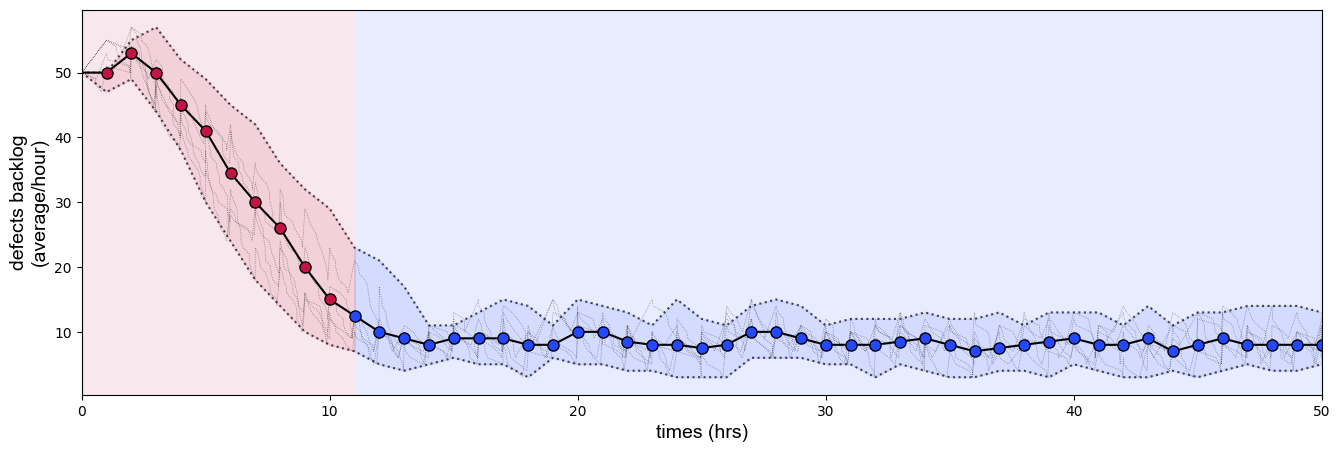

In [7]:
hourly_stats = {}
median_curve = []
min_curve = []
max_curve = []

for hour in hours[:-1]:
    hourly_stats['hour{0}'.format(hour+1)] = []
    for trial in times_forplot.keys():
        starting = times_forplot[trial].index(hours[hour])
        stopping = times_forplot[trial].index(hours[hour+1])
        hourly_stats['hour{0}'.format(hour+1)] = hourly_stats['hour{0}'.format(hour+1)] + backlog[trial][starting:stopping]
    median_curve.append(np.percentile(hourly_stats['hour{0}'.format(hour+1)],[50])[0])
    min_curve.append(min(hourly_stats['hour{0}'.format(hour+1)]))
    max_curve.append(max(hourly_stats['hour{0}'.format(hour+1)]))

colors = ['#2348FF' if value < max(median_curve)*0.2 else '#C21445' for value in median_curve]
# colors = ['green' if value < max(median_curve)*0.2 else 'yellow' for value in median_curve]
# colors = ['#C21445' for value in median_curve]


fig, ax = plt.subplots(1, 1, figsize=(16,5))

# bplot = ax.boxplot(list(hourly_stats.values()),
#                    labels=hours[1:],
#                    patch_artist=True,
#                    sym='',
#                    notch=False)
# for patch, color in zip(bplot['boxes'], colors):
#     patch.set_facecolor(color)

for trial in times_forplot.keys():
    ax.plot(times_forplot[trial], backlog[trial], ':', linewidth=0.5, color='black', alpha=0.5)
ax.plot(hours, [trial_avg[0]]+max_curve, 'k:', linewidth=1.5, alpha=0.7)
ax.plot(hours, [trial_avg[0]]+median_curve, 'k-', linewidth=1.5, alpha=1, label='average "on the hour"')
ax.plot(hours[1:11], median_curve[:10], 'o', linewidth=1.5, color='black', markersize=8, alpha=1, label='average "on the hour"')
ax.plot(hours[1:11], median_curve[:10], 'o', linewidth=1.5, color='#C21445', markersize=6, alpha=1, label='average "on the hour"')
# ax.plot(hours[1:], median_curve, 'o', linewidth=1.5, color='black', markersize=8, alpha=1, label='average "on the hour"')
# ax.plot(hours[1:], median_curve, 'o', linewidth=1.5, color='#C21445', markersize=6, alpha=1, label='average "on the hour"')

ax.plot(hours[11:], median_curve[10:], 'o', linewidth=1.5, color='black', markersize=8, alpha=1)
ax.plot(hours[11:], median_curve[10:], 'o', linewidth=1.5, color='#2348FF', markersize=6, alpha=1)
ax.plot(hours, [trial_avg[0]]+min_curve, 'k:', linewidth=1.5, alpha=0.7)
# ax.fill_between(hours[1:], median_curve, max_curve, color='red', alpha=0.1)
# ax.fill_between(hours[1:], median_curve, min_curve, color='blue', alpha=0.1)
ax.fill_between(hours[0:12], [trial_avg[0]]+min_curve[0:11], [trial_avg[0]]+max_curve[0:11], color='#C21445', alpha=0.1)
ax.fill_between(hours[11:], min_curve[10:], max_curve[10:], color='#2348FF', alpha=0.1)
# ax.fill_between(hours, [trial_avg[0]]+min_curve, [trial_avg[0]]+max_curve, color='#C21445', alpha=0.1)


GetCleanbox = [Rectangle((0,-10), 11, 90), Rectangle((11,-10), max(times_forplot[trial]), 90)]
# GetCleanbox = [Rectangle((0,-10), 10.5, 90), Rectangle((10.5,-10), 40, 90), Rectangle((50.5,-10), 12, 90), Rectangle((62.5,-10), max(times_forplot[trial]), 90)]
# GetCleanbox = [Rectangle((0,-10), max(times_forplot[trial]), 300)]
facecolor = ['#C21445', '#2348FF']
# facecolor = ['#2348FF']

# Create patch collection with specified colour/alpha
pc = PatchCollection(GetCleanbox, facecolor=facecolor, alpha=0.1,
                     edgecolor=None)

# Add collection to Axes
ax.add_collection(pc)

csfont = {'fontname':'Arial'}

ax.set_xticks(hours[::10], labels=hours[::10])
ax.set_xlim(0, max(times_forplot[trial]))
ax.set_xlabel('times (hrs)', fontsize=14, **csfont)
ax.set_ylabel('defects backlog\n(average/hour)', fontsize=14, **csfont)
# ax.legend()
# plt.savefig('Article/Figures/Answering_questions_2.svg', bbox_inches='tight')
plt.show()

#### Visualization of the sampling vs. remediation distributions

In [8]:
incoming_remediations = {key: [] for key in defect_type_dict.keys()}

for trial in comparison_dict.keys():
    for key in comparison_dict[trial]['defect_log'].keys():
        incoming_remediations[comparison_dict[trial]['defect_log'][key]['defect_type']].append(comparison_dict[trial]['defect_log'][key]['remediation_time'][0])

In [9]:
# fig, axs = plt.subplots (2, 3, figsize=(12,10))

# axs[0][0].hist(incoming_remediations['type1'], label='samples', color='#FFC200', edgecolor='black', density=True)
# axs[0][0].hist(remediation_distributions['type1'], label='theory', histtype='step', linewidth=2, color='#00B02B', density=True)
# axs[0][0].set_title('type 1')
# axs[0][0].legend()
# axs[0][0].set_xlabel('# defects per hour')
# axs[0][0].set_ylabel('density')

# axs[0][1].hist(incoming_remediations['type2'], label='samples',  color='#00B02B', edgecolor='black', density=True)
# axs[0][1].hist(remediation_distributions['type2'], label='theory', histtype='step', linewidth=2, color='#2348FF', density=True)
# axs[0][1].set_title('type 2')
# axs[0][1].legend(loc='upper left')

# axs[0][2].hist(incoming_remediations['type3'], label='samples', color='#2348FF', edgecolor='black', density=True)
# axs[0][2].hist(remediation_distributions['type3'], label='theory', histtype='step', linewidth=2, color='#C21445', density=True)
# axs[0][2].set_title('type 3')
# axs[0][2].legend(loc='upper left')

# axs[1][0].hist(incoming_remediations['type4'], label='samples', color='#2348FF', edgecolor='black', density=True)
# axs[1][0].hist(remediation_distributions['type4'], label='theory', histtype='step', linewidth=2, color='#FFC200', density=True)
# axs[1][0].set_title('type 4')
# axs[1][0].set_xlabel('# defects per hour')
# axs[1][0].set_ylabel('density')
# axs[1][0].legend(loc='upper right')

# axs[1][1].hist(incoming_remediations['type5'], label='samples', color='#00B02B', edgecolor='black', density=True)
# axs[1][1].hist(remediation_distributions['type5'], label='theory', histtype='step', linewidth=2, color='#FFC200', density=True)
# axs[1][1].set_title('type 5')
# axs[1][1].legend(loc='upper left')

# plt.show()

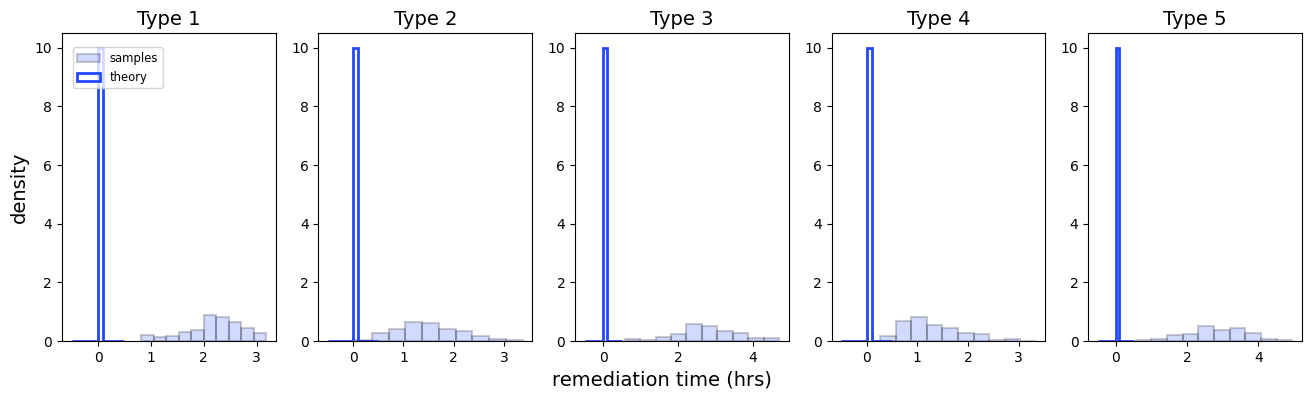

In [10]:
fig, axs = plt.subplots (1, 5, figsize=(16,4))

axs[0].hist(incoming_remediations['type1'], label='samples', color='#2348FF', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[0].hist(remediation_distributions['type1'], label='theory', histtype='step', linewidth=2, color='#2348FF', density=True)
axs[0].set_title('Type 1', fontsize=14)
axs[0].legend(loc=(0.05,0.82), fontsize='small')
# axs[0].set_xlabel('# defects per hour')
axs[0].set_ylabel('density', fontsize=14)

axs[1].hist(incoming_remediations['type2'], label='samples',  color='#2348FF', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[1].hist(remediation_distributions['type2'], label='theory', histtype='step', linewidth=2, color='#2348FF', density=True)
axs[1].set_title('Type 2', fontsize=14)
# axs[1].legend(loc='upper left')

axs[2].hist(incoming_remediations['type3'], label='samples', color='#2348FF', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[2].hist(remediation_distributions['type3'], label='theory', histtype='step', linewidth=2, color='#2348FF', density=True)
axs[2].set_title('Type 3', fontsize=14)
# axs[2].legend(loc='upper left')

axs[3].hist(incoming_remediations['type4'], label='samples', color='#2348FF', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[3].hist(remediation_distributions['type4'], label='theory', histtype='step', linewidth=2, color='#2348FF', density=True)
axs[3].set_title('Type 4', fontsize=14)
# axs[3].legend(loc='upper right')

axs[4].hist(incoming_remediations['type5'], label='samples', color='#2348FF', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[4].hist(remediation_distributions['type5'], label='theory', histtype='step', linewidth=2, color='#2348FF', density=True)
axs[4].set_title('Type 5', fontsize=14)
# axs[4].legend(loc='upper left')

fig.text(0.5, 0, 'remediation time (hrs)', ha='center', fontsize=14)
# plt.savefig('Article/Figures/Figure_1_outgoing_updated.svg', bbox_inches='tight')
plt.show()

In [11]:
incoming_defects

{'type1': [], 'type2': [], 'type3': [], 'type4': [], 'type5': []}

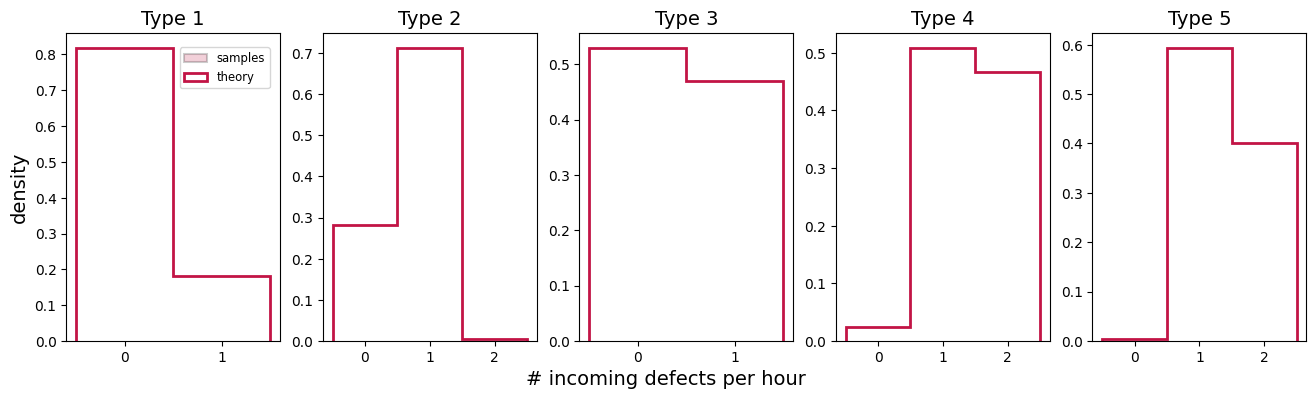

In [59]:
tnrfont = {'fontname':'Times New Roman'}
fig, axs = plt.subplots (1, 5, figsize=(16,4))

data = np.array(generation_distributions['type1'])
unique_values = np.unique(data) 
if np.all(unique_values) == 0:
    d = 1
else:
    d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
axs[0].hist(incoming_defects['type1'], np.arange(left_of_first_bin, right_of_last_bin + d, d), label='samples', color='#C21445', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[0].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='theory', linewidth=2, color='#C21445', density=True, histtype='step')
# axs[0].set_title('Type 1', fontsize=10, **tnrfont)
axs[0].set_title('Type 1', fontsize=14)
axs[0].legend(loc=(0.53,0.82), fontsize='small')
axs[0].set_xticks(np.unique(data))
axs[0].set_ylabel('density', fontsize=14)

data = np.array(generation_distributions['type2'])
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
axs[1].hist(incoming_defects['type2'], np.arange(left_of_first_bin, right_of_last_bin + d, d), label='samples', color='#C21445', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[1].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='theory', linewidth=2, color='#C21445', density=True, histtype='step')
axs[1].set_title('Type 2', fontsize=14)
axs[1].set_xticks(np.unique(data))

data = np.array(generation_distributions['type3'])
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
axs[2].hist(incoming_defects['type3'], np.arange(left_of_first_bin, right_of_last_bin + d, d), label='samples', color='#C21445', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[2].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='theory', linewidth=2, color='#C21445', density=True, histtype='step')
axs[2].set_title('Type 3', fontsize=14)
axs[2].set_xticks(np.unique(data))

data = np.array(generation_distributions['type4'])
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
axs[3].hist(incoming_defects['type4'], np.arange(left_of_first_bin, right_of_last_bin + d, d), label='samples', color='#C21445', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[3].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='theory', linewidth=2, color='#C21445', density=True, histtype='step')
axs[3].set_title('Type 4', fontsize=14)
axs[3].set_xticks(np.unique(data))

data = np.array(generation_distributions['type5'])
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
axs[4].hist(incoming_defects['type5'], np.arange(left_of_first_bin, right_of_last_bin + d, d), label='samples', color='#C21445', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
axs[4].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='theory', linewidth=2, color='#C21445', density=True, histtype='step')
axs[4].set_title('Type 5', fontsize=14)
axs[4].set_xticks(np.unique(data))

fig.text(0.5, 0, '# incoming defects per hour', ha='center', fontsize=14)
# fig.legend(['Samples', 'Theory'], loc='center right', fontsize='small')
# plt.savefig('Article/Figures/Figure_1_incoming_updated.svg', bbox_inches='tight')
plt.show()

In [14]:
# waiting_times = []
# remediation_times = []
# for trial in comparison_dict.keys():
#     for defect in comparison_dict[trial]['defect_log'].keys():
#         waiting_time = comparison_dict[trial]['defect_log'][defect]['processing_start_time'] - comparison_dict[trial]['defect_log'][defect]['t_created']
#         waiting_times.append(waiting_time)
#         try:
#             remediation_time = comparison_dict[trial]['defect_log'][defect]['processing_end_time'] - comparison_dict[trial]['defect_log'][defect]['t_created']
#             remediation_times.append(remediation_time)
#         except KeyError:
#             pass

# print(sum(waiting_times)/len(waiting_times))
# print(sum(remediation_times)/len(remediation_times))


In [15]:
# trial1_list = []
# backlog_min_v2 = []
# min_xpoints = np.arange(0,t_end+0.5,0.5)
# for value in min_xpoints:
#     time_value = min(times_forplot['trial1'], key=lambda x:abs(x-value))
#     trial1_list.append(time_value)
#     index_for_backlog = times_forplot['trial1'].index(time_value)
#     backlog_min_v2.append(backlog['trial1'][index_for_backlog])

# print(len(trial1_list), len(backlog_min_v2))
# # backlog_min

### Backlog animation

In [12]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

In [13]:
# fig, ax = plt.subplots(1,1,figsize=(16,5))
# ln1, = plt.plot([],[])
# ax.set_xlim(0,t_end)
# ax.set_ylim(0, max(backlog)+10)

# def animate(i):
#     ln1.set_data(times[:i+1], backlog[:i+1])
#     # return ln1

# ani = animation.FuncAnimation(fig, animate, frames=t_end*5, interval=20)
# ani.save('test2.gif', writer='pillow',fps=50,dpi=100)

In [14]:
for trial in times_forplot.keys():
    ax.plot(times_forplot[trial], backlog[trial], ':', linewidth=0.5, color='black', alpha=0.5)
ax.plot(hours, [trial_avg[0]]+max_curve, 'k:', linewidth=1.5, alpha=0.7)
ax.plot(hours, [trial_avg[0]]+median_curve, 'k-', linewidth=1.5, alpha=1, label='average "on the hour"')
ax.plot(hours[1:11], median_curve[:10], 'o', linewidth=1.5, color='black', markersize=8, alpha=1, label='average "on the hour"')
ax.plot(hours[1:11], median_curve[:10], 'o', linewidth=1.5, color='#C21445', markersize=6, alpha=1, label='average "on the hour"')
# ax.plot(hours[1:], median_curve, 'o', linewidth=1.5, color='black', markersize=8, alpha=1, label='average "on the hour"')
# ax.plot(hours[1:], median_curve, 'o', linewidth=1.5, color='#C21445', markersize=6, alpha=1, label='average "on the hour"')

ax.plot(hours[11:], median_curve[10:], 'o', linewidth=1.5, color='black', markersize=8, alpha=1)
ax.plot(hours[11:], median_curve[10:], 'o', linewidth=1.5, color='#2348FF', markersize=6, alpha=1)
ax.plot(hours, [trial_avg[0]]+min_curve, 'k:', linewidth=1.5, alpha=0.7)
# ax.fill_between(hours[1:], median_curve, max_curve, color='red', alpha=0.1)
# ax.fill_between(hours[1:], median_curve, min_curve, color='blue', alpha=0.1)
ax.fill_between(hours[0:12], [trial_avg[0]]+min_curve[0:11], [trial_avg[0]]+max_curve[0:11], color='#C21445', alpha=0.1)
ax.fill_between(hours[11:], min_curve[10:], max_curve[10:], color='#2348FF', alpha=0.1)
# ax.fill_between(hours, [trial_avg[0]]+min_curve, [trial_avg[0]]+max_curve, color='#C21445', alpha=0.1)

ax.fill_between(hours[0:12], [trial_avg[0]]+min_curve[0:11], [trial_avg[0]]+max_curve[0:11], color='#C21445', alpha=0.1)
ax.fill_between(hours[11:], min_curve[10:], max_curve[10:], color='#2348FF', alpha=0.1)
# ax.fill_between(hours, [trial_avg[0]]+min_curve, [trial_avg[0]]+max_curve, color='#C21445', alpha=0.1)


GetCleanbox = [Rectangle((0,-10), 11, 90), Rectangle((11,-10), max(times_forplot[trial]), 90)]
# GetCleanbox = [Rectangle((0,-10), 10.5, 90), Rectangle((10.5,-10), 40, 90), Rectangle((50.5,-10), 12, 90), Rectangle((62.5,-10), max(times_forplot[trial]), 90)]
# GetCleanbox = [Rectangle((0,-10), max(times_forplot[trial]), 300)]
facecolor = ['#C21445', '#2348FF']
# facecolor = ['#2348FF']

# Create patch collection with specified colour/alpha
pc = PatchCollection(GetCleanbox, facecolor=facecolor, alpha=0.1,
                     edgecolor=None)

# Add collection to Axes
ax.add_collection(pc)

csfont = {'fontname':'Arial'}

ax.set_xticks(hours[::10], labels=hours[::10])
ax.set_xlim(0, max(times_forplot[trial]))
ax.set_xlabel('times (hrs)', fontsize=14, **csfont)
ax.set_ylabel('defects backlog\n(average/hour)', fontsize=14, **csfont)

Text(48.80000000000001, 0.5, 'defects backlog\n(average/hour)')

In [15]:
len(times_forplot[trial])

319

In [24]:
times_forplot['trial1']

[0,
 1,
 1.6901475238471104,
 1.8914657725426178,
 2,
 2.199199863201488,
 2.2224017394223483,
 2.3387564088565904,
 2.407634245189632,
 2.428186385717574,
 2.4733206614145566,
 2.608607297913354,
 2.6404259708761155,
 2.651254177593254,
 2.7284742606561134,
 2.8032166614845924,
 2.843364178794693,
 2.943623822071986,
 3,
 3.059942685107637,
 3.4399025902992273,
 3.689617679419534,
 3.767821840566263,
 3.8737858264245246,
 3.979735071016439,
 4,
 4.192750626230289,
 4.341958607530866,
 4.513183707791542,
 4.653056089623344,
 4.696874651585188,
 4.765392727869099,
 4.8431528689948875,
 4.994511112767233,
 5,
 5.034517249796753,
 5.145234670845786,
 5.466105469328997,
 5.673422979493724,
 5.6834127519647275,
 5.687890959032033,
 5.746303707749025,
 5.9679707445147105,
 6,
 6.038423851566786,
 6.082225714539659,
 6.186189483588105,
 6.294025148912143,
 6.525446932242988,
 6.540256114245466,
 6.707447126512445,
 6.873940610845455,
 6.880807287374606,
 7,
 7.036459288949976,
 7.175076884254

In [19]:
len(backlog['trial1'])

313

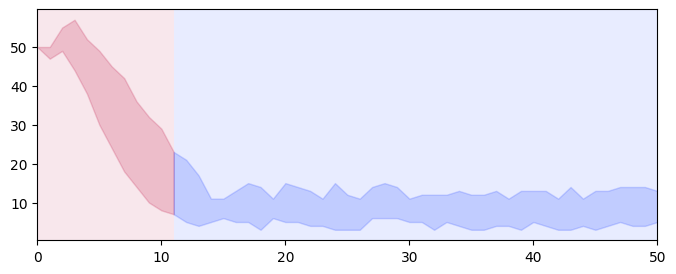

In [49]:
fig, ax = plt.subplots(figsize=(8,3))

y_max_curve = [trial_avg[0]]+max_curve
y_min_curve = [trial_avg[0]]+min_curve
y_median_curve = [trial_avg[0]]+median_curve

line_trial1 = ax.plot(times_forplot['trial1'], backlog['trial1'], ':', linewidth=0.5, color='black', alpha=0.5)[0]
line_trial2 = ax.plot(times_forplot['trial2'], backlog['trial2'], ':', linewidth=0.5, color='black', alpha=0.5)[0]
line_trial3 = ax.plot(times_forplot['trial3'], backlog['trial3'], ':', linewidth=0.5, color='black', alpha=0.5)[0]
line_trial4 = ax.plot(times_forplot['trial4'], backlog['trial4'], ':', linewidth=0.5, color='black', alpha=0.5)[0]
line_trial5 = ax.plot(times_forplot['trial5'], backlog['trial5'], ':', linewidth=0.5, color='black', alpha=0.5)[0]

line_max_curve = ax.plot(hours, y_max_curve, 'k:', linewidth=1.5, alpha=0.7)[0]
line_min_curve = ax.plot(hours, y_min_curve, 'k:', linewidth=1.5, alpha=0.7)[0]
line_median_curve = ax.plot(hours, y_median_curve, 'k-', linewidth=1.5, alpha=1)[0]

line_red_dots_1 = ax.plot(hours[1:11], median_curve[:10], 'o', linewidth=1.5, color='black', markersize=6, alpha=1)[0]
line_red_dots_2 = ax.plot(hours[1:11], median_curve[:10], 'o', linewidth=1.5, color='#C21445', markersize=4, alpha=1)[0]
line_blue_dots_1 = ax.plot(hours[11:], median_curve[10:], 'o', linewidth=1.5, color='black', markersize=6, alpha=1)[0]
line_blue_dots_2 = ax.plot(hours[11:], median_curve[10:], 'o', linewidth=1.5, color='#2348FF', markersize=4, alpha=1)[0]

GetCleanbox1 = [Rectangle((0,-10), 11, 90)]
GetCleanbox2 = [Rectangle((11,-10), 39, 90)]
# GetCleanbox = [Rectangle((0,-10), 10.5, 90), Rectangle((10.5,-10), 40, 90), Rectangle((50.5,-10), 12, 90), Rectangle((62.5,-10), max(times_forplot[trial]), 90)]
# GetCleanbox = [Rectangle((0,-10), max(times_forplot[trial]), 300)]
facecolor = ['#C21445', '#2348FF']
# facecolor = ['#2348FF']

# Create patch collection with specified colour/alpha
pc1 = PatchCollection(GetCleanbox1, facecolor=facecolor[0], alpha=0.1,
                     edgecolor=None)
pc2 = PatchCollection(GetCleanbox2, facecolor=facecolor[1], alpha=0.1,
                     edgecolor=None)

# Add collection to Axes

ax.set(xlim=[0, hours[-1]])

def update(frame):
    if frame <= 50:
        # print(frame)
        line_trial1.set_xdata(times_forplot['trial1'][:7*frame])
        line_trial1.set_ydata(backlog['trial1'][:7*frame])
        line_trial2.set_xdata(times_forplot['trial2'][:7*frame])
        line_trial2.set_ydata(backlog['trial2'][:7*frame])
        line_trial3.set_xdata(times_forplot['trial3'][:7*frame])
        line_trial3.set_ydata(backlog['trial3'][:7*frame])
        line_trial4.set_xdata(times_forplot['trial4'][:7*frame])
        line_trial4.set_ydata(backlog['trial4'][:7*frame])
        line_trial5.set_xdata(times_forplot['trial5'][:7*frame])
        line_trial5.set_ydata(backlog['trial5'][:7*frame])

        line_max_curve.set(visible=False)
        line_min_curve.set(visible=False)
        line_median_curve.set(visible=False)
        line_red_dots_1.set(visible=False)
        line_red_dots_2.set(visible=False)
        line_blue_dots_1.set(visible=False)
        line_blue_dots_2.set(visible=False)
    elif (frame > 50) and (frame < 61):
        line_red_dots_1.set(visible=True)
        line_red_dots_2.set(visible=True)
        line_max_curve.set(visible=True)
        line_min_curve.set(visible=True)
        line_median_curve.set(visible=True)
        line_red_dots_1.set_xdata(hours[1:frame-50+1])
        line_red_dots_1.set_ydata(median_curve[:frame-50])
        line_red_dots_2.set_xdata(hours[1:frame-50+1])
        line_red_dots_2.set_ydata(median_curve[:frame-50])
        # line_blue_dots_1.set(visible=False)
        # line_blue_dots_2.set(visible=False)
        # line_blue_dots_1.set_ydata(0)
        # line_blue_dots_2.set_xdata(0)
        # line_blue_dots_2.set_ydata(0)
        line_max_curve.set_xdata(hours[:frame-50])
        line_max_curve.set_ydata(y_max_curve[:frame-50])
    
        line_min_curve.set_xdata(hours[:frame-50])
        line_min_curve.set_ydata(y_min_curve[:frame-50])
    
        line_median_curve.set_xdata(hours[:frame-50])
        line_median_curve.set_ydata(y_median_curve[:frame-50])
    else:
        line_blue_dots_1.set(visible=True)
        line_blue_dots_2.set(visible=True)
        line_red_dots_1.set_xdata(hours[1:11])
        line_red_dots_1.set_ydata(median_curve[:10])
        line_red_dots_2.set_xdata(hours[1:11])
        line_red_dots_2.set_ydata(median_curve[:10])
        line_blue_dots_1.set_xdata(hours[11:frame-50+1])
        line_blue_dots_1.set_ydata(median_curve[10:frame-50])
        line_blue_dots_2.set_xdata(hours[11:frame-50+1])
        line_blue_dots_2.set_ydata(median_curve[10:frame-50])
        line_max_curve.set_xdata(hours[:frame-50])
        line_max_curve.set_ydata(y_max_curve[:frame-50])
    
        line_min_curve.set_xdata(hours[:frame-50])
        line_min_curve.set_ydata(y_min_curve[:frame-50])
    
        line_median_curve.set_xdata(hours[:frame-50])
        line_median_curve.set_ydata(y_median_curve[:frame-50])
        if frame == 102:
            ax.fill_between(hours[0:12], [trial_avg[0]]+min_curve[0:11], [trial_avg[0]]+max_curve[0:11], color='#C21445', alpha=0.1)
            ax.fill_between(hours[11:], min_curve[10:], max_curve[10:], color='#2348FF', alpha=0.1)
            # ax.fill_between(hours, [trial_avg[0]]+min_curve, [trial_avg[0]]+max_curve, color='#C21445', alpha=0.1)
            
            ax.fill_between(hours[0:12], [trial_avg[0]]+min_curve[0:11], [trial_avg[0]]+max_curve[0:11], color='#C21445', alpha=0.1)
            ax.fill_between(hours[11:], min_curve[10:], max_curve[10:], color='#2348FF', alpha=0.1)
            ax.add_collection(pc1)
            ax.add_collection(pc2)
        
    # line_max_curve.set_xdata(hours[:frame])
    # line_max_curve.set_ydata(y_max_curve[:frame])

    # line_min_curve.set_xdata(hours[:frame])
    # line_min_curve.set_ydata(y_min_curve[:frame])

    # line_median_curve.set_xdata(hours[:frame])
    # line_median_curve.set_ydata(y_median_curve[:frame])
    # return (line_red_dots_1, line_red_dots_2, line_blue_dots_1, line_blue_dots_2, line_max_curve, line_min_curve, line_median_curve)
    return (line_trial1, line_red_dots_1, line_red_dots_2, line_blue_dots_1, line_blue_dots_2, line_max_curve, line_min_curve, line_median_curve)

ani = animation.FuncAnimation(fig=fig, func=update, frames=150, interval=500)
ani.save('test2.gif', writer='pillow',fps=7,dpi=100)
# plt.show()